<a href="https://colab.research.google.com/github/jinyjib98/AI_Sprint_Project/blob/main/AI_05_%EA%B9%80%ED%98%95%EC%A7%84_Section1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section Project

### Goal of the Project
> 다음 분기에 어떤 게임을 설계해야 할까

### What we should get from data
1. **지역**에 따라서 선호하는 **게임 장르**가 다른지
2. **연도별** 게임의 **트렌드**가 있는지
3. **출고량**이 많은 게임에 대한 분석 및 시각화 프로세스

### Personal analysis
1. 지역별 게임 산업의 크기
2. 지역 내 장르별 경쟁 정도



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats

### 전처리(pre-processing)

In [2]:
url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv'



# 데이터 불러오기
df = pd.read_csv(url)
df = df.drop('Unnamed: 0', axis=1)
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [3]:
# type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [4]:
df.shape

(16598, 9)

In [5]:
# K나 M단위가 표시되어 있지 않은 출고량 대부분 소숫점, 단위 불분명
# 따라서 K나 M단위가 표시되어 있지 않은 출고량은 M(1,000,000)으로 가정함

# M단위 제거
df['EU_Sales'] = df['EU_Sales'].str.replace('M','')
df['JP_Sales'] = df['JP_Sales'].str.replace('M','')
df['NA_Sales'] = df['NA_Sales'].str.replace('M','')
df['Other_Sales'] = df['Other_Sales'].str.replace('M','')

# K단위 제거
df['NA_Sales'] = df['NA_Sales'].str.replace('K','')
df['EU_Sales'] = df['EU_Sales'].str.replace('K','')
df['JP_Sales'] = df['JP_Sales'].str.replace('K','')
df['Other_Sales'] = df['Other_Sales'].str.replace('K','')

# 숫자열로 변환
df['NA_Sales'] = pd.to_numeric(df['NA_Sales'])
df['EU_Sales'] = pd.to_numeric(df['EU_Sales'])
df['JP_Sales'] = pd.to_numeric(df['JP_Sales'])
df['Other_Sales'] = pd.to_numeric(df['Other_Sales'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  float64
 6   EU_Sales     16598 non-null  float64
 7   JP_Sales     16598 non-null  float64
 8   Other_Sales  16598 non-null  float64
dtypes: float64(5), object(4)
memory usage: 1.1+ MB


In [6]:
#df = df.sort_values(by='NA_Sales', ascending=False)
#df = df[df['NA_Sales'] >= 10]
#df

In [7]:
df1 = df.copy()
# 1K = 0.001M -> K단위를 M단위로 통일

for i in range(0, len(df1)):
    if df1.loc[i,'NA_Sales'] >= 20:
        df1.loc[i,'NA_Sales'] = df1.loc[i,'NA_Sales'] * 0.001

for i in range(0, len(df1)):
    if df1.loc[i,'EU_Sales'] >= 20:
        df1.loc[i,'EU_Sales'] = df1.loc[i,'EU_Sales'] * 0.001

for i in range(0, len(df1)):
    if df1.loc[i,'JP_Sales'] >= 20:
        df1.loc[i,'JP_Sales'] = df1.loc[i,'JP_Sales'] * 0.001

for i in range(0, len(df1)):
    if df1.loc[i,'Other_Sales'] >= 20:
        df1.loc[i,'Other_Sales'] = df1.loc[i,'Other_Sales'] * 0.001

df = df1

In [8]:
# Year, Genre 결측치 행 제거
# 분석시에 결측치가 있으면 결과가 왜곡될 수 있는 경우만 제거 
# Year, Genre는 내가 하고자 하는 분석의 핵심이므로 결측치는 제거한 후 분석

df_drop_row = df.dropna(subset=['Year','Genre'])
df_drop_row = df_drop_row.reset_index()
df_drop_row = df_drop_row.drop('index',axis=1)
df_drop_row.shape

# df.shape = (16598, 9)
# 약 320개 삭제

(16277, 9)

In [9]:
# Year 표현 방식이 다른 것 통일 (2자리수로 표현된 것 4자리수로)
for i in range(0, len(df_drop_row)):
    if df_drop_row.loc[i, 'Year'] <=20:
        df_drop_row.loc[i, 'Year'] += 2000
    elif (df_drop_row.loc[i, 'Year'] >= 80) & (df_drop_row.loc[i, 'Year'] <= 99):
        df_drop_row.loc[i, 'Year'] += 1900

### 전처리 완료한 최종 데이터

In [10]:
game = df_drop_row
game.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04


### 출고량 비교

In [11]:
sales = game.loc[:,'NA_Sales':'Other_Sales']
sales.head()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,0.04,0.00,0.00,0.00
1,0.17,0.00,0.00,0.01
2,0.00,0.00,0.02,0.00
3,0.04,0.00,0.00,0.00
4,0.12,0.09,0.00,0.04


In [12]:
sales.describe()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
count,16277.000000,16277.000000,16277.000000,16277.000000
mean,0.258784,0.148489,0.079953,0.054271
std,0.674672,0.486271,0.337034,0.310989
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.040000
max,15.850000,12.880000,10.220000,10.570000


In [13]:
# 지역별 출고량 차이가 나는지 anova로 검증

In [14]:
from scipy.stats import normaltest
import matplotlib.pyplot as plt

In [15]:
sales_NA = sales['NA_Sales'][sales['NA_Sales'] != 0]
sales_EU = sales['EU_Sales'][sales['EU_Sales'] != 0]
sales_JP = sales['JP_Sales'][sales['JP_Sales'] != 0]
sales_Other = sales['Other_Sales'][sales['Other_Sales'] != 0]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


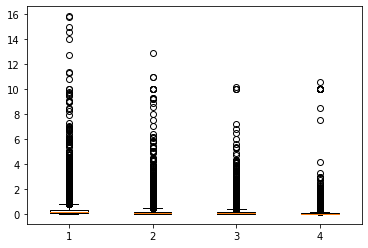

In [16]:
data = [sales_NA, sales_EU, sales_JP, sales_Other]
plt.boxplot(data)
plt.show()

In [17]:
# ANOVA
# Null.hy = 지역 간 출고량 평균의 차이가 없다.
# Alter.hy = 지역 간 출고량 평균의 차이가 있다.(적어도 한 지역의 평균은 다르다)

stats.f_oneway(sales_NA, sales_EU, sales_JP, sales_Other)

# p-value가 매우 작은 값이므로, 유의수준 5% 하에서 귀무가설 기각, 대립가설 채택
# 즉, 4개 지역 간 평균 출고량의 차이가 존재한다고 볼 수 있다. (적어도 한 지역의 평균은 다르다)

F_onewayResult(statistic=356.8665043322707, pvalue=1.2776098761751193e-228)

### 시장의 전체적인 규모 파악

In [18]:
game['Total_Sales'] = game['EU_Sales'] + game['JP_Sales'] + game['NA_Sales'] + game['Other_Sales']
game.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25


In [19]:
game['Total_Sales'].sum()

8813.939719999998

In [20]:
NA_total_pie = sales['NA_Sales'].sum()
EU_total_pie = sales['EU_Sales'].sum()
JP_total_pie = sales['JP_Sales'].sum()
Other_total_pie = sales['Other_Sales'].sum()

print(NA_total_pie)
print(EU_total_pie)
print(JP_total_pie)
print(Other_total_pie)

4212.2207
2416.9590200000002
1301.39
883.37


### 연대별 게임 시장 규모

In [21]:
bins = list(range(1980, 2021, 10))

bins_label = [str(x)+'~' for x in bins]

game['range'] = pd.cut(game['Year'], bins, right=False, labels=bins_label[:-1])

# range별 게임 개수
range = game.range.value_counts().to_frame() 
range

,range
2000~,9178
2010~,5130
1990~,1764
1980~,204


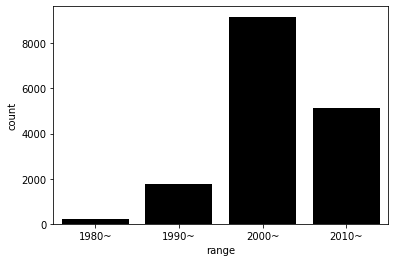

In [22]:
rg = sns.countplot(x='range', data=game, color='#000000')


In [23]:
# range별 출고량 변화
total_by_range = game['Total_Sales'].groupby(game['range']) 
total_by_range.sum()


range
1980~     296.84921
1990~    1285.18000
2000~    4659.76051
2010~    2571.86000
Name: Total_Sales, dtype: float64

### 시장 내의 평균 출고량 파악 
전체 시장 규모를 해당 시장에 출시한 게임 수로 나누는 것을 통해 어느 시장에서 우리 게임이 가장 많은 pie를 가질 수 있을지 알아봄

In [24]:
# how competitive the market is (평균 출고량)
compet_NA = NA_total_pie / len(sales_NA)
compet_EU = EU_total_pie / len(sales_EU)
compet_JP = JP_total_pie / len(sales_JP)
compet_Other = Other_total_pie / len(sales_Other)

print(compet_NA)
print(compet_EU)
print(compet_JP)
print(compet_Other)

0.35555167552966993
0.22660407087943
0.21439703459637563
0.08895971802618328


### 지역별 선호 장르 파악
출고된 게임 개수, 출고량 기준으로 파악

In [25]:
# 출고량과 장르 chisquare test (독립성 검증)
# Null.hy = 두 변수는 독립적이다 (연관 X)
# Alter.hy = 두 변수는 독립적이지 않다 (연관 O)

In [26]:
fav_genre = game[['Genre','NA_Sales','EU_Sales','JP_Sales','Other_Sales']]
fav_genre_sum = fav_genre.groupby('Genre').sum()

print('p-value is: ', stats.chi2_contingency(fav_genre_sum)[1])

# 출고량과 장르는 관련이 있다

p-value is:  1.3719498331315393e-116


In [27]:
# 출고된 게임 개수

In [28]:
game_NA = game.loc[game['NA_Sales'] != 0]
game_EU = game.loc[game['EU_Sales'] != 0]
game_JP = game.loc[game['JP_Sales'] != 0]
game_Other = game.loc[game['Other_Sales'] != 0]

In [29]:
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000', '#ece322']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.show()

In [30]:
Genre_list = ['Action','Adventure','Fighting','Misc','Platform','Puzzle','Racing','Role-Playing','Shooter','Simulation','Sports','Strategy']

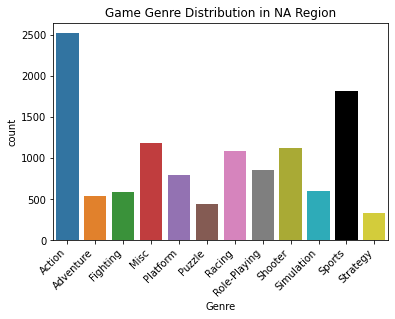

In [31]:
na = sns.countplot(x='Genre',data=game_NA, order = Genre_list)
na.set_xticklabels(na.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Game Genre Distribution in NA Region')
plt.show()

nafig = na.get_figure()
nafig.savefig('genre_distribution_NA.png', dpi = 200, bbox_inches='tight', pad_inches=0.3, transparent=True)

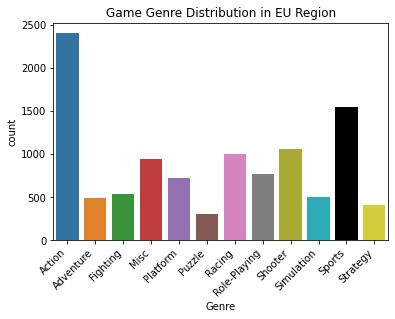

In [32]:
eu = sns.countplot(x='Genre',data=game_EU, order=Genre_list)
eu.set_xticklabels(eu.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Game Genre Distribution in EU Region')
plt.show()

eufig = eu.get_figure()
eufig.savefig('genre_distribution_EU.png', dpi = 200, bbox_inches='tight', pad_inches=0.3, transparent=True)

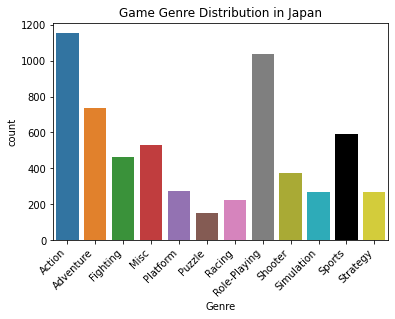

In [33]:
jp = sns.countplot(x='Genre',data=game_JP, order=Genre_list)
jp.set_xticklabels(jp.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Game Genre Distribution in Japan')
plt.show()

jpfig = jp.get_figure()
jpfig.savefig('genre_distribution_JP.png', dpi = 200, bbox_inches='tight', pad_inches=0.3, transparent=True)

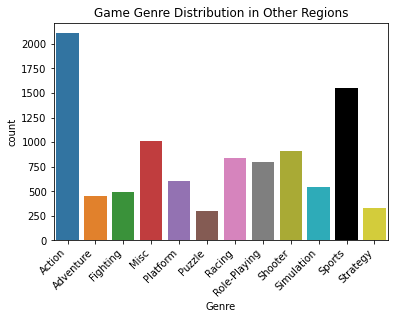

In [34]:
ot = sns.countplot(x='Genre',data=game_Other, order=Genre_list)
ot.set_xticklabels(ot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Game Genre Distribution in Other Regions')
plt.show()

otfig = ot.get_figure()
otfig.savefig('genre_distribution_Other.png', dpi = 200, bbox_inches='tight', pad_inches=0.3, transparent=True)

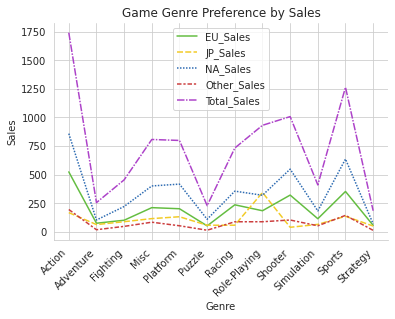

In [35]:
# 출고량 기준 지역별 성향
total_pref = game.groupby(by=['Genre'])['Total_Sales'].sum()
total_pref = total_pref.reset_index()

na_pref = game.groupby(by=['Genre'])['NA_Sales'].sum()
na_pref = na_pref.reset_index()

eu_pref = game.groupby(by=['Genre'])['EU_Sales'].sum()
eu_pref = eu_pref.reset_index()

jp_pref = game.groupby(by=['Genre'])['JP_Sales'].sum()
jp_pref = jp_pref.reset_index()

ot_pref = game.groupby(by=['Genre'])['Other_Sales'].sum()
ot_pref = ot_pref.reset_index()

total_pref = total_pref.combine_first(eu_pref).combine_first(jp_pref).combine_first(ot_pref).combine_first(na_pref)
total_pref = total_pref.set_index('Genre')

#total_pref


sns.set_style('whitegrid')
plt.title('Game Genre Preference by Sales')
plt.xlabel('Genre')
plt.ylabel('Sales')

pf = sns.lineplot(data=total_pref, palette=['#64bd41','#f2cb27','#2d6bb2','#cc3e3e','#ad42c9'])
pf.set_xticklabels(labels=Genre_list, rotation=45, horizontalalignment='right')
sns.despine()
plt.show()

pffig = pf.get_figure()
pffig.savefig('game_genre_pref.png', dpi = 200, bbox_inches='tight', pad_inches=0.3, transparent=True)

In [36]:
# 전체적으로 Action, Sport, Misc 장르 게임 출시하는 경우 많음
# 일본의 경우 다른 지역과 다르게 role-playing 장르 선호도가 높은 것이 특징

### 연도별 게임 트렌드 파악

In [37]:
# 장르에 따른 게임 개수

In [38]:
trend_gr = game[['Year', 'Genre']]
trend_table_gr = pd.crosstab(trend_gr.Year, trend_gr.Genre)
trend_table_gr.head()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
1980.0,1,0,1,4,0,0,0,0,2,0,0,0
1981.0,25,0,0,0,3,2,1,0,10,1,4,0
1982.0,18,0,0,1,5,3,2,0,5,0,2,0
1983.0,7,1,0,1,5,1,0,0,1,0,1,0
1984.0,1,0,0,1,1,3,3,0,3,0,2,0


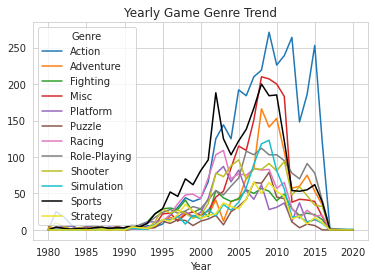

In [39]:
tt = trend_table_gr.plot()
plt.title("Yearly Game Genre Trend")
plt.show()

ttfig = tt.get_figure()
ttfig.savefig('yearly_game_genre_trend.png', dpi = 200, bbox_inches='tight', pad_inches=0.3, transparent=True)

In [40]:
# 연도별 각 플랫폼에서 출시한 게임 개수

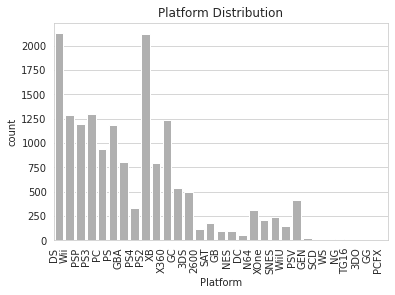

In [41]:
sales_total = game.loc[game['Total_Sales'] != 0]

platform = sns.countplot(x='Platform',data=sales_total, color='#b0b0b0')
platform.set_xticklabels(platform.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.title('Platform Distribution')
plt.show()

pffig = platform.get_figure()
pffig.savefig('platform_distribution.png', dpi = 200, bbox_inches='tight', pad_inches=0.3, transparent=True)

In [42]:
# platform 종류 파악
list = []

for i in game['Platform']:
    list.append(i)

platform_list = []
for v in list:
    if v not in platform_list:
        platform_list.append(v)
print(platform_list)

['DS', 'Wii', 'PSP', 'PS3', 'PC', 'PS', 'GBA', 'PS4', 'PS2', 'XB', 'X360', 'GC', '3DS', '2600', 'SAT', 'GB', 'NES', 'DC', 'N64', 'XOne', 'SNES', 'WiiU', 'PSV', 'GEN', 'SCD', 'WS', 'NG', 'TG16', '3DO', 'GG', 'PCFX']


In [43]:
trend_pf = game[['Year','Platform']]
trend_table_pf = pd.crosstab(trend_pf.Year, trend_pf.Platform)
trend_table_pf.head()

Platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1980.0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1981.0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1982.0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1983.0,11,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1984.0,1,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


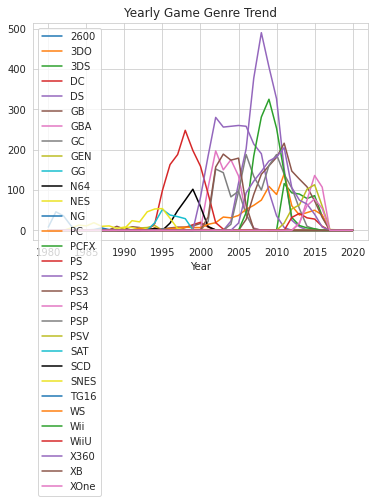

In [44]:
pf = trend_table_pf.plot()
plt.title("Yearly Game Genre Trend")
plt.legend(loc='upper left')
plt.show()

ttfig = tt.get_figure()

### 출고량이 많은 게임 분석
최근 동향을 알아보기 위해 **2010년 이후 출시**된 게임을 중심으로 분석함

#### 전체적 추세 (total sale 기준)

In [45]:
recent_game = game.sort_values(by='Year', ascending=False)
recent_game = recent_game.loc[recent_game['Year'] >= 2010]
recent_game.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,range
6776,Imagine: Makeup Artist,DS,2020.0,Simulation,Ubisoft,0.27,0.0,0.00,0.02,0.29,NaN
14937,Phantasy Star Online 2 Episode 4: Deluxe Package,PSV,2017.0,Role-Playing,Sega,0.00,0.0,0.01,0.00,0.01,2010~
9929,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,0.00,0.0,0.03,0.00,0.03,2010~
5206,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,0.00,0.0,0.01,0.00,0.01,2010~
13142,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2016.0,Misc,Namco Bandai Games,0.00,0.0,0.02,0.00,0.02,2010~


In [46]:
sorted_game_total = recent_game.sort_values(by='Total_Sales', ascending=False)
top20_total = sorted_game_total.head(20)
top20_total

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,range
4260,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67,21.82,2010~
3420,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39,2010~
10714,Grand Theft Auto V,X360,2013.0,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38,2010~
10429,Pokemon Black/Pokemon White,DS,2010.0,Role-Playing,Nintendo,5.57,3.28,5.65,0.82,15.32,2010~
2762,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,Activision,9.03,4.28,0.13,1.32,14.76,2010~
6130,Call of Duty: Black Ops,X360,2010.0,Shooter,Activision,9.67,3.73,0.11,1.13,14.64,2010~
8909,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,Activision,5.77,5.81,0.35,2.31,14.24,2010~
4159,Call of Duty: Black Ops II,PS3,2012.0,Shooter,Activision,4.99,5.88,0.65,2.52,14.04,2010~
6268,Call of Duty: Black Ops II,X360,2012.0,Shooter,Activision,8.25,4.30,0.07,1.12,13.74,2010~
13844,Call of Duty: Modern Warfare 3,PS3,2011.0,Shooter,Activision,5.54,5.82,0.49,1.62,13.47,2010~


### 장르

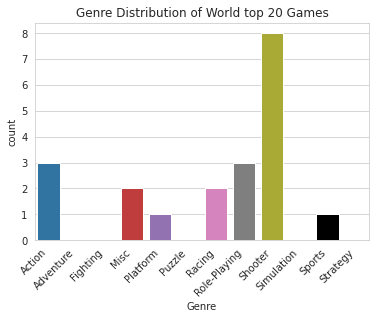

In [47]:
total20 = sns.countplot(x='Genre',data=top20_total, order=Genre_list)
total20.set_xticklabels(total20.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Genre Distribution of World top 20 Games')
plt.show()

tt20fig = total20.get_figure()
tt20fig.savefig('genre_distribution_world20.png', dpi = 200, bbox_inches='tight', pad_inches=0.3, transparent=True)

In [91]:
def ratio_top_20_tt(genre):
    ratio = top20_total.loc[top20_total['Genre'] == genre]
    return ratio['Total_Sales'].sum()

print(top20_total['Total_Sales'].sum())
print(ratio_top_20_tt('Action'), ratio_top_20_tt('Misc'), ratio_top_20_tt('Platform'), ratio_top_20_tt('Racing'), ratio_top_20_tt('Role-Playing'), ratio_top_20_tt('Shooter'), ratio_top_20_tt('Sports'))

270.62
49.75999999999999 32.09 10.79 22.98 37.019999999999996 107.83000000000001 10.15


### 플랫폼

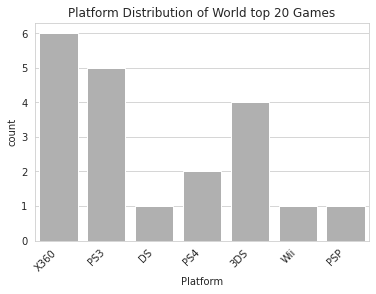

In [48]:
total20p = sns.countplot(x='Platform',data=top20_total, color='#b0b0b0')
total20p.set_xticklabels(total20p.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Platform Distribution of World top 20 Games')
plt.show()

tt20pfig = total20p.get_figure()
tt20pfig.savefig('platform_distribution_world20.png', dpi = 200, bbox_inches='tight', pad_inches=0.3, transparent=True)

In [92]:
#XBOX = ['X360']
#Playstation = ['PS3', 'PS4', 'PSP']
#Nintendo = ['Wii','DS','3DS']

x360_tt = top20_total.loc[top20_total['Platform'] == 'X360']
ps3_tt = top20_total.loc[top20_total['Platform'] == 'PS3']
ps4_tt = top20_total.loc[top20_total['Platform'] == 'PS4']
psp_tt = top20_total.loc[top20_total['Platform'] == 'PSP']
wii_tt = top20_total.loc[top20_total['Platform'] == 'Wii']
ds_tt = top20_total.loc[top20_total['Platform'] == 'DS']
ds3_tt = top20_total.loc[top20_total['Platform'] == '3DS']

xbox_tt = x360_tt
playstation_tt = pd.concat([ps3_tt, ps4_tt, psp_tt])
nintendo_tt = pd.concat([wii_tt, ds_tt, ds3_tt])

def sum_pf_tt(dataframe):
    return dataframe['Total_Sales'].sum()

tt_pf_sales = top20_total['Total_Sales'].sum()
print(tt_pf_sales)
print(sum_pf_tt(xbox_tt) + sum_pf_tt(playstation_tt) + sum_pf_tt(nintendo_tt))
print(sum_pf_tt(xbox_tt), sum_pf_tt(playstation_tt),sum_pf_tt(nintendo_tt))

270.62
270.62
91.55000000000001 108.78 70.28999999999999


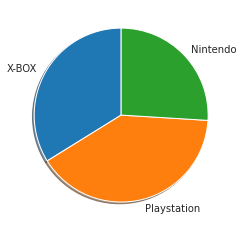

In [95]:
ratio_pf_tt = [sum_pf_tt(xbox_tt)/tt_pf_sales, sum_pf_tt(playstation_tt)/tt_pf_sales,sum_pf_tt(nintendo_tt)/tt_pf_sales]
label = ['X-BOX', 'Playstation','Nintendo']

plt.pie(ratio_pf_tt, labels=label, shadow=True, startangle=90)
plt.show()

#### 북미 지역 추세

In [49]:
sorted_game_NA = recent_game.sort_values(by='NA_Sales', ascending=False)
top20_NA = sorted_game_NA.head(20)
top20_NA

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,range
4260,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67,21.82,2010~
12099,The Cages: Pro Style Batting Practice,Wii,2010.0,Sports,Konami Digital Entertainment,10.00,0.00,0.00,0.00,10.00,2010~
6130,Call of Duty: Black Ops,X360,2010.0,Shooter,Activision,9.67,3.73,0.11,1.13,14.64,2010~
10714,Grand Theft Auto V,X360,2013.0,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38,2010~
2762,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,Activision,9.03,4.28,0.13,1.32,14.76,2010~
6268,Call of Duty: Black Ops II,X360,2012.0,Shooter,Activision,8.25,4.30,0.07,1.12,13.74,2010~
12362,Halo: Reach,X360,2010.0,Shooter,Microsoft Game Studios,7.03,1.98,0.08,0.78,9.87,2010~
3420,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39,2010~
5500,Call of Duty: Ghosts,X360,2013.0,Shooter,Activision,6.72,2.63,0.04,0.82,10.21,2010~
14297,Halo 4,X360,2012.0,Shooter,Microsoft Game Studios,6.63,2.36,0.04,0.73,9.76,2010~


#### 장르

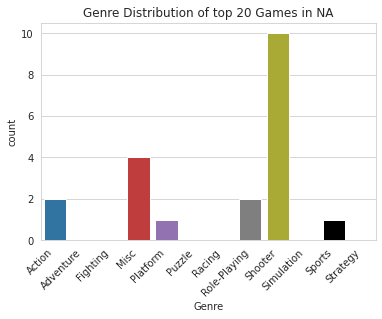

In [50]:
na20 = sns.countplot(x='Genre',data=top20_NA, order=Genre_list)
na20.set_xticklabels(na20.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Genre Distribution of top 20 Games in NA')
plt.show()

na20fig = na20.get_figure()
na20fig.savefig('genre_distribution_NA20.png', dpi = 200, bbox_inches='tight', pad_inches=0.3, transparent=True)

In [66]:
def ratio_top_20(genre):
    ratio = top20_NA.loc[top20_NA['Genre'] == genre]
    return ratio['NA_Sales'].sum()

print(top20_NA['NA_Sales'].sum())
print(ratio_top_20('Action'), ratio_top_20('Misc'), ratio_top_20('Platform'), ratio_top_20('Role-Playing'), ratio_top_20('Shooter'), ratio_top_20('Sports'))

144.18
16.64 32.44 4.89 10.600000000000001 69.61 10.0


In [ ]:
# 시리즈 게임 비중

In [114]:
call_of_duty = top20_NA['NA_Sales'].loc[top20_NA['Name'].str.contains('Call of Duty')].sum()
halo = top20_NA['NA_Sales'].loc[top20_NA['Name'].str.contains('Halo')].sum()
total = top20_NA['NA_Sales'].sum()
other = total - halo - call_of_duty

In [115]:
print(call_of_duty)
print(halo)
print(other)

55.95
13.66
74.57000000000001


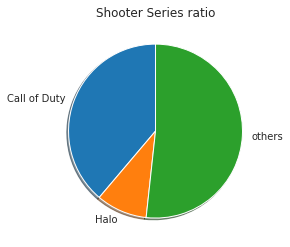

In [117]:
ratio_series = [call_of_duty/ total, halo / total, other / total]
labels = ['Call of Duty', 'Halo','others']

plt.pie(ratio_series, labels=labels, shadow=True, startangle=90)
plt.title('Shooter Series ratio')
plt.show()

#### 플랫폼

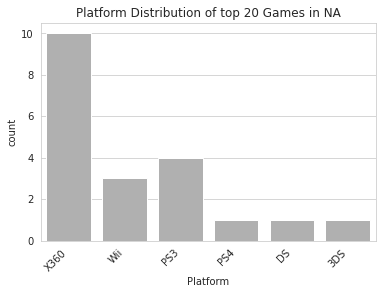

In [51]:
na20p = sns.countplot(x='Platform',data=top20_NA, color='#b0b0b0')
na20p.set_xticklabels(na20p.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Platform Distribution of top 20 Games in NA')
plt.show()

na20pfig =na20p.get_figure()
na20pfig.savefig('platform_distribution_NA20.png', dpi = 200, bbox_inches='tight', pad_inches=0.3, transparent=True)

In [ ]:
# 각 플랫폼별 출고량 비율

In [83]:
#XBOX = ['X360']
#Playstation = ['PS3', 'PS4']
#Nintendo = ['Wii','DS','3DS']

x360 = top20_NA.loc[top20_NA['Platform'] == 'X360']
ps3 = top20_NA.loc[top20_NA['Platform'] == 'PS3']
ps4 = top20_NA.loc[top20_NA['Platform'] == 'PS4']
wii = top20_NA.loc[top20_NA['Platform'] == 'Wii']
ds = top20_NA.loc[top20_NA['Platform'] == 'DS']
ds3 = top20_NA.loc[top20_NA['Platform'] == '3DS']

In [85]:
xbox = x360
playstation = pd.concat([ps3, ps4])
nintendo = pd.concat([wii, ds, ds3])

In [87]:
def sum_pf(dataframe):
    return dataframe['NA_Sales'].sum()

In [93]:
total_pf_sales = top20_NA['NA_Sales'].sum()
print(total_pf_sales)
print(sum_pf(xbox) + sum_pf(playstation) + sum_pf(nintendo))
print(sum_pf(xbox)/total_pf_sales, sum_pf(playstation)/total_pf_sales,sum_pf(nintendo)/total_pf_sales)

144.18
144.18
0.5724788458870856 0.20314884172562075 0.22437231238729366


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.


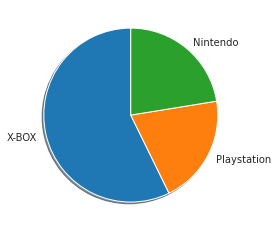

In [94]:
ratio_pf = [(sum_pf(xbox)/total_pf_sales, sum_pf(playstation)/total_pf_sales,sum_pf(nintendo)/total_pf_sales)]
label = ['X-BOX', 'Playstation','Nintendo']

plt.pie(ratio_pf, labels=label, shadow=True, startangle=90)
plt.show()

In [52]:
# 전체적 추세 뿐만 아니라 북미 지역에서도 x-box, playstation, nintendo와 같은 주요 콘솔 플랫폼을 선택하는 것이 출고량 측면에서 유리